<a href="https://colab.research.google.com/github/Roy-Byun/IDC2808-Casual-Model-for-Bias-Detection-and-Mitigation-for-CNN/blob/main/casual_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
install.packages("lavaan")
install.packages("nnet")
install.packages("googledrive")
install.packages("dplyr")
install.packages("tidyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [98]:
library("lavaan")
library("nnet")
library("googledrive")
library("dplyr")
library("tidyr")

In [99]:
# Authenticate and mount Google Drive
drive_auth(scopes = c("https://www.googleapis.com/auth/drive"))


The googledrive package is requesting access to your Google account.
Enter '1' to start a new auth process or select a pre-authorized account.
1: Send me to the browser for a new auth process.
2: academic.roika.uses@gmail.com


Selection: 2


In [100]:
file_id <- "1cw0C4tzIQIOHGnB2hwZCXTb-zQP1omhq03bTFtbOME8"
drive_download(as_id(file_id), path = "data.csv", overwrite = TRUE)



Auto-refreshing stale OAuth token.

File downloaded:

• test_predictions <id: 1cw0C4tzIQIOHGnB2hwZCXTb-zQP1omhq03bTFtbOME8>

Saved locally as:

• data.csv



In [101]:
# Read the CSV into a dataframe
data <- read.csv("data.csv")
head(data)

,file,age,gender,race,service_test,image_path,angry,disgust,fear,happy,⋯,set,emotion_encoded,pred_angry,pred_disgust,pred_fear,pred_happy,pred_neutral,pred_sad,pred_surprise,pred_dominant_emotion
,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,val/1269.jpg,20-29,Female,East Asian,FALSE,/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/1269.jpg,4.1539691,0.0005425039,1.656175e+00,8.754689e-02,⋯,val,4,0.03514380,0.002285881,0.08279880,0.09479114,0.5673999,0.2085685,0.009011921,neutral
2,val/8609.jpg,20-29,Male,Southeast Asian,TRUE,/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/8609.jpg,7.6796679,0.3187014807,5.887059e+01,4.713769e-02,⋯,val,2,0.09615987,0.003617336,0.08916902,0.01487149,0.3847439,0.4024809,0.008957511,sad
3,val/10024.jpg,20-29,Male,Black,FALSE,/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/10024.jpg,0.1374362,0.0000000171,2.352087e-03,9.478812e-01,⋯,val,4,0.04268722,0.000743211,0.01335575,0.02731055,0.7540942,0.1592955,0.002513579,neutral
4,val/1695.jpg,20-29,Male,Southeast Asian,TRUE,/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/1695.jpg,69.0098345,0.0000000077,7.946858e-02,3.359739e-04,⋯,val,0,0.21173555,0.001597813,0.02623859,0.02440022,0.3284020,0.4053957,0.002230090,sad
5,val/8219.jpg,20-29,Male,Middle Eastern,TRUE,/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/8219.jpg,4.9099679,0.0112926099,6.545527e+00,1.588660e+00,⋯,val,5,0.11357626,0.006283884,0.14535478,0.12307832,0.3382777,0.2478852,0.025543863,neutral
6,val/3903.jpg,10-19,Male,White,TRUE,/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/3903.jpg,0.0000269,0.0000004570,2.348464e-04,9.999740e+01,⋯,val,3,0.32413808,0.008224904,0.10323457,0.12733549,0.2131242,0.2112593,0.012683422,angry


In [102]:
# Visualize the structure of the dataset
str(data)

'data.frame':	5477 obs. of  24 variables:
 $ file                 : chr  "val/1269.jpg" "val/8609.jpg" "val/10024.jpg" "val/1695.jpg" ...
 $ age                  : chr  "20-29" "20-29" "20-29" "20-29" ...
 $ gender               : chr  "Female" "Male" "Male" "Male" ...
 $ race                 : chr  "East Asian" "Southeast Asian" "Black" "Southeast Asian" ...
 $ service_test         : logi  FALSE TRUE FALSE TRUE TRUE TRUE ...
 $ image_path           : chr  "/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/1269.jpg" "/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/8609.jpg" "/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/10024.jpg" "/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/1695.jpg" ...
 $ angry                : num  4.154 7.68 0.137 69.01 4.91 ...
 $ disgust              : num  5.43e-04 3.19e-01 1.71e-08 7.70e-09 1.13

In [103]:
# One-Hot Encoding of True Emotions class

# Define emotions
emotions <- c("angry", "disgust", "fear", "happy", "neutral", "sad", "surprise")

# One-hot encoding for True Classification
true_class <- as.data.frame(t(sapply(data$dominant_emotion, function(x) as.integer(emotions == x))))
colnames(true_class) <- paste0("true_", emotions)


In [104]:
# Retain original columns and add only binarized emotions
model_data <- data %>%
  bind_cols(true_class)

# View the updated dataset
head(model_data)


,file,age,gender,race,service_test,image_path,angry,disgust,fear,happy,⋯,pred_sad,pred_surprise,pred_dominant_emotion,true_angry,true_disgust,true_fear,true_happy,true_neutral,true_sad,true_surprise
,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
neutral,val/1269.jpg,20-29,Female,East Asian,FALSE,/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/1269.jpg,4.1539691,0.0005425039,1.656175e+00,8.754689e-02,⋯,0.2085685,0.009011921,neutral,0,0,0,0,1,0,0
fear,val/8609.jpg,20-29,Male,Southeast Asian,TRUE,/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/8609.jpg,7.6796679,0.3187014807,5.887059e+01,4.713769e-02,⋯,0.4024809,0.008957511,sad,0,0,1,0,0,0,0
neutral.1,val/10024.jpg,20-29,Male,Black,FALSE,/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/10024.jpg,0.1374362,0.0000000171,2.352087e-03,9.478812e-01,⋯,0.1592955,0.002513579,neutral,0,0,0,0,1,0,0
angry,val/1695.jpg,20-29,Male,Southeast Asian,TRUE,/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/1695.jpg,69.0098345,0.0000000077,7.946858e-02,3.359739e-04,⋯,0.4053957,0.002230090,sad,1,0,0,0,0,0,0
sad,val/8219.jpg,20-29,Male,Middle Eastern,TRUE,/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/8219.jpg,4.9099679,0.0112926099,6.545527e+00,1.588660e+00,⋯,0.2478852,0.025543863,neutral,0,0,0,0,0,1,0
happy,val/3903.jpg,10-19,Male,White,TRUE,/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/3903.jpg,0.0000269,0.0000004570,2.348464e-04,9.999740e+01,⋯,0.2112593,0.012683422,angry,0,0,0,1,0,0,0


In [105]:
str(model_data)

'data.frame':	5477 obs. of  31 variables:
 $ file                 : chr  "val/1269.jpg" "val/8609.jpg" "val/10024.jpg" "val/1695.jpg" ...
 $ age                  : chr  "20-29" "20-29" "20-29" "20-29" ...
 $ gender               : chr  "Female" "Male" "Male" "Male" ...
 $ race                 : chr  "East Asian" "Southeast Asian" "Black" "Southeast Asian" ...
 $ service_test         : logi  FALSE TRUE FALSE TRUE TRUE TRUE ...
 $ image_path           : chr  "/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/1269.jpg" "/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/8609.jpg" "/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/10024.jpg" "/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val/1695.jpg" ...
 $ angry                : num  4.154 7.68 0.137 69.01 4.91 ...
 $ disgust              : num  5.43e-04 3.19e-01 1.71e-08 7.70e-09 1.13

In [106]:
# Save the dataset as a CSV file in the local environment
write.csv(model_data, "binarized_test__predicted_data.csv", row.names = FALSE)

# Upload the file to Google Drive
drive_upload(
  media = "binarized_test__predicted_data.csv",
  path = "binarized_test__predicted_data.csv"
)

# Confirm upload
cat("File has been saved and uploaded to Google Drive!")

Local file:

• binarized_test__predicted_data.csv

Uploaded into Drive file:

• binarized_test__predicted_data.csv <id: 1KHYUwbZLr7eDGOdXTD-qQRsEiUA6ObrL>

With MIME type:

• text/csv



File has been saved and uploaded to Google Drive!

In [107]:
names(model_data)

[1] "file"                  "age"                   "gender"               
 [4] "race"                  "service_test"          "image_path"           
 [7] "angry"                 "disgust"               "fear"                 
[10] "happy"                 "sad"                   "surprise"             
[13] "neutral"               "dominant_emotion"      "set"                  
[16] "emotion_encoded"       "pred_angry"            "pred_disgust"         
[19] "pred_fear"             "pred_happy"            "pred_neutral"         
[22] "pred_sad"              "pred_surprise"         "pred_dominant_emotion"
[25] "true_angry"            "true_disgust"          "true_fear"            
[28] "true_happy"            "true_neutral"          "true_sad"             
[31] "true_surprise"

### Visualize the Data

In [108]:
# Define the list of emotions
emotions <- c("angry", "disgust", "fear", "happy", "neutral", "sad", "surprise")

# Step 2: Create a new column 'True_Emotion' by finding which 'true_*' column is 1
model_data$True_Emotion <- apply(model_data[, paste0('true_', emotions)], 1, function(x) emotions[which(x == 1)])

# Step 3: Compare 'pred_dominant_emotion' with 'True_Emotion' to check if the prediction is correct
model_data$Prediction_Correct <- model_data$pred_dominant_emotion == model_data$True_Emotion

# Step 4: Convert logical values to 'True' and 'False' labels for clarity
model_data$Prediction_Correct_Label <- ifelse(model_data$Prediction_Correct, 'True', 'False')

# Step 5: Aggregate the counts based on 'gender', 'True_Emotion', and 'Prediction_Correct_Label'
summary_table <- model_data %>%
  group_by(True_Emotion,gender, Prediction_Correct_Label) %>%
  summarise(Count = n(), .groups = 'drop') %>%
  pivot_wider(names_from = Prediction_Correct_Label, values_from = Count, values_fill = 0)

# Assuming 'summary_table' is your data frame
# Add a new column for accuracy
summary_table <- summary_table %>%
  mutate(
    Total = True + False,
    Accuracy = (True / Total) * 100
  )

# Display the updated table
print(summary_table)

# A tibble: 14 × 6
   True_Emotion gender False  True Total Accuracy
   <chr>        <chr>  <int> <int> <int>    <dbl>
 1 angry        Female   167     9   176     5.11
 2 angry        Male     264    42   306    13.7 
 3 disgust      Female     5     0     5     0   
 4 disgust      Male       8     0     8     0   
 5 fear         Female   232    48   280    17.1 
 6 fear         Male     227    55   282    19.5 
 7 happy        Female   140   864  1004    86.1 
 8 happy        Male     161   501   662    75.7 
 9 neutral      Female   210   425   635    66.9 
10 neutral      Male     244   738   982    75.2 
11 sad          Female   244   231   475    48.6 
12 sad          Male     304   276   580    47.6 
13 surprise     Female    33     1    34     2.94
14 surprise     Male      46     2    48     4.17


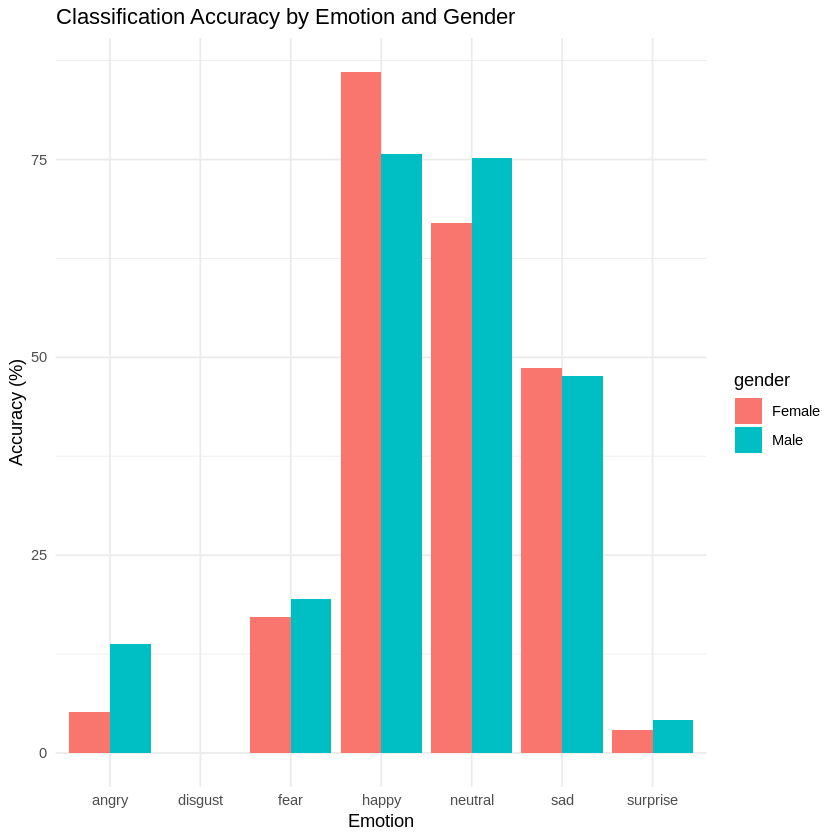

In [109]:
library(ggplot2)

# Prepare data for plotting
accuracy_plot_data <- summary_table %>%
  select(True_Emotion, gender, Accuracy)

# Plot
ggplot(accuracy_plot_data, aes(x = True_Emotion, y = Accuracy, fill = gender)) +
  geom_bar(stat = 'identity', position = 'dodge') +
  labs(title = 'Classification Accuracy by Emotion and Gender',
       x = 'Emotion',
       y = 'Accuracy (%)') +
  theme_minimal()


In [110]:
# Function to perform proportion test for each emotion
# Proportion test between groups focus on comparing group-level outcomes (male vs female accuracy) fo each emotion categories

# But SEM Model explores relationships between variables, include direct, indirect, and mediated effect to account for complex interrelationships between predictors and outcomes
# Determining how gender and true emotion collectively affect predicted probabilities and uncovering latent biases in the model.
perform_proportion_test <- function(data, emotion) {
  subset_data <- data %>% filter(True_Emotion == emotion)

  female_true <- subset_data %>% filter(gender == 'Female') %>% pull(True)
  female_total <- subset_data %>% filter(gender == 'Female') %>% summarise(Total = sum(True + False)) %>% pull(Total)

  male_true <- subset_data %>% filter(gender == 'Male') %>% pull(True)
  male_total <- subset_data %>% filter(gender == 'Male') %>% summarise(Total = sum(True + False)) %>% pull(Total)

  test_result <- prop.test(
    x = c(female_true, male_true),
    n = c(female_total, male_total),
    alternative = "two.sided",
    correct = FALSE
  )

  return(data.frame(
    Emotion = emotion,
    Female_Accuracy = (female_true / female_total) * 100,
    Male_Accuracy = (male_true / male_total) * 100,
    p_value = test_result$p.value
  ))
}

# Perform the test for each emotion
emotions_list <- unique(summary_table$True_Emotion)
test_results <- do.call(rbind, lapply(emotions_list, function(e) perform_proportion_test(summary_table, e)))

# Display the test results
print(test_results)


Warning message in prop.test(x = c(female_true, male_true), n = c(female_total, :
“Chi-squared approximation may be incorrect”
Warning message in prop.test(x = c(female_true, male_true), n = c(female_total, :
“Chi-squared approximation may be incorrect”


   Emotion Female_Accuracy Male_Accuracy      p_value
1    angry        5.113636     13.725490 3.081718e-03
2  disgust        0.000000      0.000000          NaN
3     fear       17.142857     19.503546 4.695293e-01
4    happy       86.055777     75.679758 7.180403e-08
5  neutral       66.929134     75.152749 3.260067e-04
6      sad       48.631579     47.586207 7.352770e-01
7 surprise        2.941176      4.166667 7.708926e-01


In [111]:
# Aggregate the total True and False counts for each gender
# Overall Accuracy
overall_accuracy <- model_data %>%
  group_by(gender) %>%
  summarise(
    Total_True = sum(Prediction_Correct),
    Total_Count = n()
  ) %>%
  mutate(
    Accuracy = (Total_True / Total_Count) * 100
  )

# Display the overall accuracy table
print(overall_accuracy)

# A tibble: 2 × 4
  gender Total_True Total_Count Accuracy
  <chr>       <int>       <int>    <dbl>
1 Female       1578        2609     60.5
2 Male         1614        2868     56.3


In [112]:
# # Extract counts for the test
# female_correct <- overall_accuracy %>% filter(gender == 'Female') %>% pull(Total_True)
# female_total <- overall_accuracy %>% filter(gender == 'Female') %>% pull(Total_Count)

# male_correct <- overall_accuracy %>% filter(gender == 'Male') %>% pull(Total_True)
# male_total <- overall_accuracy %>% filter(gender == 'Male') %>% pull(Total_Count)

# # Perform a proportion test
# prop_test_result <- prop.test(
#   x = c(female_correct, male_correct),
#   n = c(female_total, male_total),
#   alternative = "two.sided",
#   correct = FALSE
# )

# # Display the test results
# print(prop_test_result)


Convert Gender into Binary Encoding (Male: 1, Female: 0)

In [113]:
# Convert 'gender' to numeric (0 for Female, 1 for Male)
model_data$Gender_Binary <- ifelse(model_data$gender == "Male", 1, 0)

In [114]:
# Anger
sem_model_angry <- '
  # Regression equations
  pred_angry ~ 1 + true_angry + Gender_Binary
  true_angry ~ 1 + Gender_Binary
'

# Happy
sem_model_happy <- '
  # Regression equations
  pred_happy ~ 1 + true_happy + Gender_Binary
  true_happy ~ 1 + Gender_Binary
'

# Sad
sem_model_sad <- '
  # Regression equations
  pred_sad ~ 1 + true_sad + Gender_Binary
  true_sad ~ 1 + Gender_Binary
'

# Fear
sem_model_fear <- '
  # Regression equations
  pred_fear ~ 1 + true_fear + Gender_Binary
  true_fear ~ 1 + Gender_Binary
'

# Disgust
sem_model_disgust <- '
  # Regression equations
  pred_disgust ~ 1 + true_disgust + Gender_Binary
  true_disgust ~ 1 + Gender_Binary
'

# Neutral
sem_model_neutral <- '
  # Regression equations
  pred_neutral ~ 1 + true_neutral + Gender_Binary
  true_neutral ~ 1 + Gender_Binary
'

# Surprise
sem_model_surprise <- '
  # Regression equations
  pred_surprise ~ 1 + true_surprise + Gender_Binary
  true_surprise ~ 1 + Gender_Binary
'


In [115]:
# Create a list of SEM models for all emotions
sem_models <- list(
  angry = sem_model_angry,
  happy = sem_model_happy,
  sad = sem_model_sad,
  fear = sem_model_fear,
  disgust = sem_model_disgust,
  neutral = sem_model_neutral,
  surprise = sem_model_surprise
)

# Fit each SEM model and store results
sem_results <- lapply(sem_models, function(model) {
  fit <- sem(model, data = model_data, missing = "ML")
  summary(fit, standardized = FALSE, fit.measures = TRUE)
})

Warning message:
“lavaan->lav_mvnorm_missing_h1_estimate_moments():  
   The smallest eigenvalue of the EM estimated variance-covariance matrix 
   (Sigma) is smaller than 1e-05; this may cause numerical instabilities; 
   interpret the results with caution.”
Warning message:
“lavaan->lav_model_vcov():  
   The variance-covariance matrix of the estimated parameters (vcov) does not 
   appear to be positive definite! The smallest eigenvalue (= 3.388883e-14) 
   is close to zero. This may be a symptom that the model is not identified.”


### Detect Significance of Beta using Causal Model

In [116]:
# View results for each emotion
sem_results$angry

lhs,op,rhs,exo,est,se,z,pvalue
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
pred_angry,~1,,0,0.058907277,0.0014565789,40.442214,0.000000e+00
pred_angry,~,true_angry,0,0.091074716,0.0035097645,25.948953,0.000000e+00
pred_angry,~,Gender_Binary,0,0.026932053,0.0019908688,13.527789,0.000000e+00
true_angry,~1,,0,0.067458796,0.0055331196,12.191820,0.000000e+00
true_angry,~,Gender_Binary,0,0.039235764,0.0076463091,5.131334,2.876962e-07
pred_angry,~~,pred_angry,0,0.005389058,0.0001029809,52.330679,0.000000e+00
true_angry,~~,true_angry,0,0.079875610,0.0015263629,52.330679,0.000000e+00
Gender_Binary,~~,Gender_Binary,1,0.249440946,0.0000000000,NA,NA
Gender_Binary,~1,,1,0.523644331,0.0000000000,NA,NA


In [117]:
sem_results$happy

lhs,op,rhs,exo,est,se,z,pvalue
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
pred_happy,~1,,0,0.18095447,0.005335311,33.916389,0
pred_happy,~,true_happy,0,0.52841960,0.007005663,75.427490,0
pred_happy,~,Gender_Binary,0,-0.05772604,0.006453267,-8.945242,0
true_happy,~1,,0,0.38482177,0.008880177,43.334923,0
true_happy,~,Gender_Binary,0,-0.15399890,0.012271662,-12.549147,0
pred_happy,~~,pred_happy,0,0.05530425,0.001056823,52.330679,0
true_happy,~~,true_happy,0,0.20573931,0.003931524,52.330679,0
Gender_Binary,~~,Gender_Binary,1,0.24944095,0.000000000,NA,NA
Gender_Binary,~1,,1,0.52364433,0.000000000,NA,NA


In [118]:
sem_results$sad

lhs,op,rhs,exo,est,se,z,pvalue
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
pred_sad,~1,,0,0.14371920,0.0031139003,46.154078,0.000000e+00
pred_sad,~,true_sad,0,0.17837000,0.0051940779,34.341033,0.000000e+00
pred_sad,~,Gender_Binary,0,0.02441215,0.0041012614,5.952352,2.643155e-09
true_sad,~1,,0,0.18206209,0.0077181656,23.588778,0.000000e+00
true_sad,~,Gender_Binary,0,0.02016943,0.0106658603,1.891027,5.862077e-02
pred_sad,~~,pred_sad,0,0.02296476,0.0004388393,52.330678,0.000000e+00
true_sad,~~,true_sad,0,0.15541834,0.0029699279,52.330678,0.000000e+00
Gender_Binary,~~,Gender_Binary,1,0.24944095,0.0000000000,NA,NA
Gender_Binary,~1,,1,0.52364433,0.0000000000,NA,NA


In [119]:
sem_results$fear

lhs,op,rhs,exo,est,se,z,pvalue
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
pred_fear,~1,,0,0.0852838533,0.001783219,47.82577553,0.0000000
pred_fear,~,true_fear,0,0.0964292859,0.003940584,24.47080809,0.0000000
pred_fear,~,Gender_Binary,0,0.0001316176,0.002394219,0.05497306,0.9561599
true_fear,~1,,0,0.1073208126,0.005940220,18.06680717,0.0000000
true_fear,~,Gender_Binary,0,-0.0089944527,0.008208888,-1.09569683,0.2732115
pred_fear,~~,pred_fear,0,0.0078296652,0.000149619,52.33067935,0.0000000
true_fear,~~,true_fear,0,0.0920617371,0.001759231,52.33067985,0.0000000
Gender_Binary,~~,Gender_Binary,1,0.2494409456,0.000000000,NA,NA
Gender_Binary,~1,,1,0.5236443308,0.000000000,NA,NA


In [120]:
sem_results$disgust

lhs,op,rhs,exo,est,se,z,pvalue
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
pred_disgust,~1,,0,3.139166e-03,6.074934e-05,51.6740726,0.000000e+00
pred_disgust,~,true_disgust,0,4.816634e-03,8.613507e-04,5.5919545,2.245277e-08
pred_disgust,~,Gender_Binary,0,2.648490e-04,8.392289e-05,3.1558612,1.600250e-03
true_disgust,~1,,0,1.916443e-03,9.526422e-04,2.0117134,4.425016e-02
true_disgust,~,Gender_Binary,0,8.729572e-04,1.316472e-03,0.6631036,5.072642e-01
pred_disgust,~~,pred_disgust,0,9.621361e-06,1.840892e-07,52.2646678,0.000000e+00
true_disgust,~~,true_disgust,0,2.367738e-03,4.524570e-05,52.3306793,0.000000e+00
Gender_Binary,~~,Gender_Binary,1,2.494409e-01,0.000000e+00,NA,NA
Gender_Binary,~1,,1,5.236443e-01,0.000000e+00,NA,NA


In [121]:
sem_results$neutral

lhs,op,rhs,exo,est,se,z,pvalue
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
pred_neutral,~1,,0,0.19396996,0.0041884125,46.311092,0.000000e+00
pred_neutral,~,true_neutral,0,0.28022675,0.0059779445,46.876773,0.000000e+00
pred_neutral,~,Gender_Binary,0,0.05390080,0.0054597647,9.872367,0.000000e+00
true_neutral,~1,,0,0.24338827,0.0088777275,27.415605,0.000000e+00
true_neutral,~,Gender_Binary,0,0.09901061,0.0122682779,8.070457,6.661338e-16
pred_neutral,~~,pred_neutral,0,0.04024614,0.0007690735,52.330679,0.000000e+00
true_neutral,~~,true_neutral,0,0.20562584,0.0039293555,52.330679,0.000000e+00
Gender_Binary,~~,Gender_Binary,1,0.24944095,0.0000000000,NA,NA
Gender_Binary,~1,,1,0.52364433,0.0000000000,NA,NA


In [122]:
sem_results$surprise

lhs,op,rhs,exo,est,se,z,pvalue
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
pred_surprise,~1,,0,0.0127827356,4.501999e-04,28.393467,0.000000e+00
pred_surprise,~,true_surprise,0,0.0549243045,2.551957e-03,21.522425,0.000000e+00
pred_surprise,~,Gender_Binary,0,-0.0007961771,6.205109e-04,-1.283099,1.994572e-01
true_surprise,~1,,0,0.0130318101,2.377237e-03,5.481915,4.207467e-08
true_surprise,~,Gender_Binary,0,0.0037045869,3.285143e-03,1.127679,2.594555e-01
pred_surprise,~~,pred_surprise,0,0.0005259064,1.004968e-05,52.330679,0.000000e+00
true_surprise,~~,true_surprise,0,0.0147441245,2.817491e-04,52.330680,0.000000e+00
Gender_Binary,~~,Gender_Binary,1,0.2494409456,0.000000e+00,NA,NA
Gender_Binary,~1,,1,0.5236443308,0.000000e+00,NA,NA


## Mitigation Method



In [123]:
# Fit each SEM model and store fitted models
sem_fits <- lapply(sem_models, function(model) {
  fit <- sem(model, data = model_data, missing = "ML")
  return(fit)
})

# Assign names to the list elements
names(sem_fits) <- names(sem_models)

Warning message:
“lavaan->lav_mvnorm_missing_h1_estimate_moments():  
   The smallest eigenvalue of the EM estimated variance-covariance matrix 
   (Sigma) is smaller than 1e-05; this may cause numerical instabilities; 
   interpret the results with caution.”
Warning message:
“lavaan->lav_model_vcov():  
   The variance-covariance matrix of the estimated parameters (vcov) does not 
   appear to be positive definite! The smallest eigenvalue (= 3.388883e-14) 
   is close to zero. This may be a symptom that the model is not identified.”


Extract parameters of Emotion which has p-value less than 0.05

In [124]:
# Initialize lists to store emotions with significant Gender effect
significant_emotions <- c()
bias_coefficients <- c()

# Loop over each emotion to extract parameters
for (emotion in names(sem_fits)) {
  fit <- sem_fits[[emotion]]

  # Extract parameter estimates
  params <- parameterEstimates(fit)

  # Find the row corresponding to Gender_Binary effect on predicted emotion
  param_row <- params %>%
    filter(lhs == paste0("pred_", emotion) & rhs == "Gender_Binary")

  # Check if param_row is not empty
  if (nrow(param_row) == 0) {
    next  # Skip if Gender_Binary effect is not found
  }

  # Extract the estimate and p-value
  beta_gender <- param_row$est
  p_value <- param_row$pvalue

  # Check if p-value < 0.05
  if (!is.na(p_value) && p_value < 0.05) {
    significant_emotions <- c(significant_emotions, emotion)
    bias_coefficients <- c(bias_coefficients, beta_gender)
  }
}

# Create a data frame with significant emotions and their bias coefficients
bias_info <- data.frame(
  emotion = significant_emotions,
  beta_gender = bias_coefficients
)
print(bias_info)

  emotion  beta_gender
1   angry  0.026932053
2   happy -0.057726037
3     sad  0.024412153
4 disgust  0.000264849
5 neutral  0.053900802


Creation of Logit Columns + Copying original probabilites

In [125]:
# List of emotions
emotions <- c("angry", "disgust", "fear", "happy", "neutral", "sad", "surprise")

# Step 1: Copy predicted probabilities to 'logit_' columns (no actual logit transformation here)
for (emotion in emotions) {
  prob_column <- paste0('pred_', emotion)
  logit_column <- paste0('logit_', emotion)

  # Assign predicted probabilities to 'logit_' columns
  model_data[[logit_column]] <- (model_data[[prob_column]] )
}

Adjust Logit for Emotions with Bias Introduced by subtracting the weight of gender bias

In [126]:
# Step 2: Adjust the "logits" for emotions with significant gender bias
for (i in seq_along(bias_info$emotion)) {
  emotion <- bias_info$emotion[i]
  beta_gender <- bias_info$beta_gender[i]

  logit_column <- paste0('logit_', emotion)
  adj_logit_column <- paste0('logit_', emotion, '_adj') # Adjusted "logit" column

  # Subtract the gender bias from the logits
  model_data[[adj_logit_column]] <- model_data[[logit_column]] - beta_gender * model_data$Gender_Binary
}

Rescale the adjusted logits to match the original scale.

In [127]:
# Step 3: Rescale adjusted logits to match the original scale for biased emotions
# This ensures that adjusted logits have the same min and max values as the original logits
model_data$logit_angry_adj = min(model_data$logit_angry)+(model_data$logit_angry_adj-min(model_data$logit_angry_adj))*(max(model_data$logit_angry)-min(model_data$logit_angry))/(max(model_data$logit_angry_adj)-min(model_data$logit_angry_adj))
model_data$logit_happy_adj = min(model_data$logit_happy)+(model_data$logit_happy_adj-min(model_data$logit_happy_adj))*(max(model_data$logit_happy)-min(model_data$logit_happy))/(max(model_data$logit_happy_adj)-min(model_data$logit_happy_adj))
model_data$logit_sad_adj = min(model_data$logit_sad)+(model_data$logit_sad_adj-min(model_data$logit_sad_adj))*(max(model_data$logit_sad)-min(model_data$logit_sad))/(max(model_data$logit_sad_adj)-min(model_data$logit_sad_adj))
model_data$logit_disgust_adj = min(model_data$logit_disgust)+(model_data$logit_disgust_adj-min(model_data$logit_disgust_adj))*(max(model_data$logit_disgust)-min(model_data$logit_disgust))/(max(model_data$logit_disgust_adj)-min(model_data$logit_disgust_adj))
model_data$logit_neutral_adj = min(model_data$logit_neutral)+(model_data$logit_neutral_adj-min(model_data$logit_neutral_adj))*(max(model_data$logit_neutral)-min(model_data$logit_neutral))/(max(model_data$logit_neutral_adj)-min(model_data$logit_neutral_adj))

# Step 4: Summarize the original and adjusted logits for comparison
summary(model_data$logit_angry)
summary(model_data$logit_angry_adj)
summary(model_data$logit_happy)
summary(model_data$logit_happy_adj)
summary(model_data$logit_sad)
summary(model_data$logit_sad_adj)
summary(model_data$logit_disgust)
summary(model_data$logit_disgust_adj)
summary(model_data$logit_neutral)
summary(model_data$logit_neutral_adj)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000036 0.0206512 0.0624778 0.0810251 0.1156037 0.6462339 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000036 0.0364880 0.0757140 0.0938280 0.1278222 0.6462339 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0001306 0.0352659 0.1296947 0.3114618 0.5989177 0.9993316 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0001306 0.0721168 0.1536105 0.3234046 0.5916155 0.9993316 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000324 0.0420519 0.1548875 0.1908608 0.2978826 0.8682731 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000324 0.0543822 0.1605029 0.1968784 0.2995567 0.8682731 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
5.790e-07 8.546e-04 2.425e-03 3.289e-03 4.841e-03 2.839e-02 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
5.790e-07 9.775e-04 2.525e-03 3.413e-03 4.968e-03 2.839e-02 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000711 0.1149623 0.2459269 0.3049274 0.4547520 0.9855292 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000711 0.1331214 0.2581074 0.3158164 0.4536814 0.9855292 

Emotions without bias are unadjsuted



In [128]:
# Step 5: For emotions without significant bias, copy original logits to adjusted logits
for (emotion in setdiff(emotions, bias_info$emotion)) {
  logit_column <- paste0('logit_', emotion)
  adj_logit_column <- paste0('logit_', emotion, '_adj')

  model_data[[adj_logit_column]] <- model_data[[logit_column]]
}

# Step 6: Summarize adjusted logits for all emotions
summary(model_data$logit_angry_adj)
summary(model_data$logit_happy_adj)
summary(model_data$logit_sad_adj)
summary(model_data$logit_disgust_adj)
summary(model_data$logit_neutral_adj)
summary(model_data$logit_fear_adj)
summary(model_data$logit_surprise_adj)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000036 0.0364880 0.0757140 0.0938280 0.1278222 0.6462339 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0001306 0.0721168 0.1536105 0.3234046 0.5916155 0.9993316 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000324 0.0543822 0.1605029 0.1968784 0.2995567 0.8682731 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
5.790e-07 9.775e-04 2.525e-03 3.413e-03 4.968e-03 2.839e-02 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000711 0.1331214 0.2581074 0.3158164 0.4536814 0.9855292 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000578 0.0241028 0.0668727 0.0952475 0.1355609 0.5972042 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000167 0.0029486 0.0065389 0.0131881 0.0136840 0.4495460 

Recompute the adjusted probabilities using the Softmax function

In [129]:
# Step 7: Prepare adjusted logits for softmax computation
adj_logit_columns <- paste0('logit_', emotions, '_adj')
adj_logits_matrix <- as.matrix(model_data[, adj_logit_columns])

# Step 8: Apply the softmax function to obtain adjusted probabilities
exp_adj_logits <- exp(adj_logits_matrix)
sum_exp_adj_logits <- rowSums(exp_adj_logits)

# Calculate adjusted probabilities by dividing exponentials by the sum
adj_prob_matrix <- exp_adj_logits / sum_exp_adj_logits

# Step 9: Store adjusted probabilities back into the data frame
adj_prob_columns <- paste0('pred_', emotions, '_adj')
model_data[, adj_prob_columns] <- adj_prob_matrix

Update the predicted dominant emotion

In [130]:
# Step 10: Determine the predicted dominant emotion after adjustment
model_data$pred_dominant_emotion_adj <- apply(model_data[, adj_prob_columns], 1, function(x) {
  emotions[which.max(x)]
})

### Evaluation & Visualization

Evaluate the impact of Mitigation (Comparing Accuracy before and after)

In [131]:
# Prepare data for plotting
library(dplyr)
library(tidyr)
library(ggplot2)


model_data$Prediction_Correct_Before <- model_data$pred_dominant_emotion == model_data$True_Emotion
model_data$Prediction_Correct_After <- model_data$pred_dominant_emotion_adj == model_data$True_Emotion

Compare Accuracy by Gender and Emotion

`summarise()` has grouped output by 'True_Emotion'. You can override using the
`.groups` argument.


# A tibble: 14 × 4
# Groups:   True_Emotion [7]
   True_Emotion gender Accuracy_Before Accuracy_After
   <chr>        <chr>            <dbl>          <dbl>
 1 angry        Female            5.11           6.82
 2 angry        Male             13.7           14.1 
 3 disgust      Female            0              0   
 4 disgust      Male              0              0   
 5 fear         Female           17.1           14.3 
 6 fear         Male             19.5           19.1 
 7 happy        Female           86.1           84.9 
 8 happy        Male             75.7           78.4 
 9 neutral      Female           66.9           70.4 
10 neutral      Male             75.2           73.3 
11 sad          Female           48.6           48.2 
12 sad          Male             47.6           47.8 
13 surprise     Female            2.94           2.94
14 surprise     Male              4.17           4.17


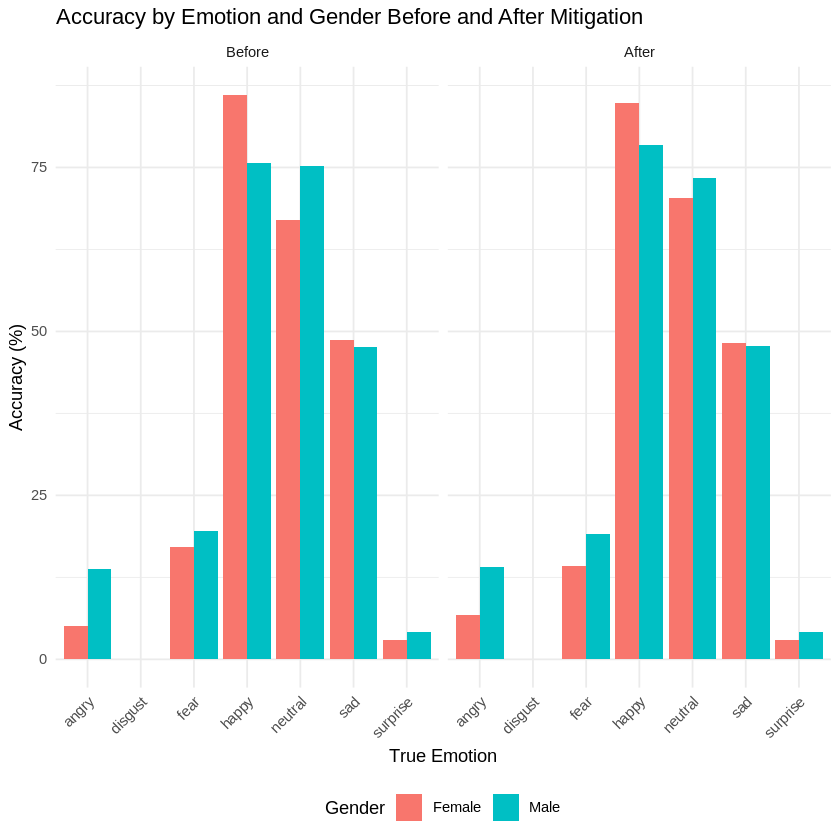

In [132]:
emotion_gender_accuracy <- model_data %>%
  group_by(True_Emotion, gender) %>%
  summarise(
    Count = n(),
    Correct_Before = sum(Prediction_Correct_Before),
    Correct_After = sum(Prediction_Correct_After)
  ) %>%
  mutate(
    Accuracy_Before = (Correct_Before / Count) * 100,
    Accuracy_After = (Correct_After / Count) * 100
  ) %>%
  select(True_Emotion, gender, Accuracy_Before, Accuracy_After) %>%
  arrange(True_Emotion, gender)

print(emotion_gender_accuracy)

accuracy_long <- emotion_gender_accuracy %>%
  pivot_longer(
    cols = c("Accuracy_Before", "Accuracy_After"),
    names_to = "Condition",
    values_to = "Accuracy"
  ) %>%
  mutate(
    # Simplify the Condition labels
    Condition = factor(Condition, levels = c("Accuracy_Before", "Accuracy_After"), labels = c("Before", "After"))
  )

# Plot the accuracy by emotion and gender before and after mitigation
ggplot(accuracy_long, aes(x = True_Emotion, y = Accuracy, fill = gender)) +
  geom_bar(stat = 'identity', position = 'dodge') +
  facet_wrap(~ Condition) +
  labs(
    title = 'Accuracy by Emotion and Gender Before and After Mitigation',
    x = 'True Emotion',
    y = 'Accuracy (%)',
    fill = 'Gender'
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "bottom"
  )

Compare Accuracy by Gender

# A tibble: 2 × 3
  gender Accuracy_Before Accuracy_After
  <chr>            <dbl>          <dbl>
1 Female            60.5           60.6
2 Male              56.3           56.3


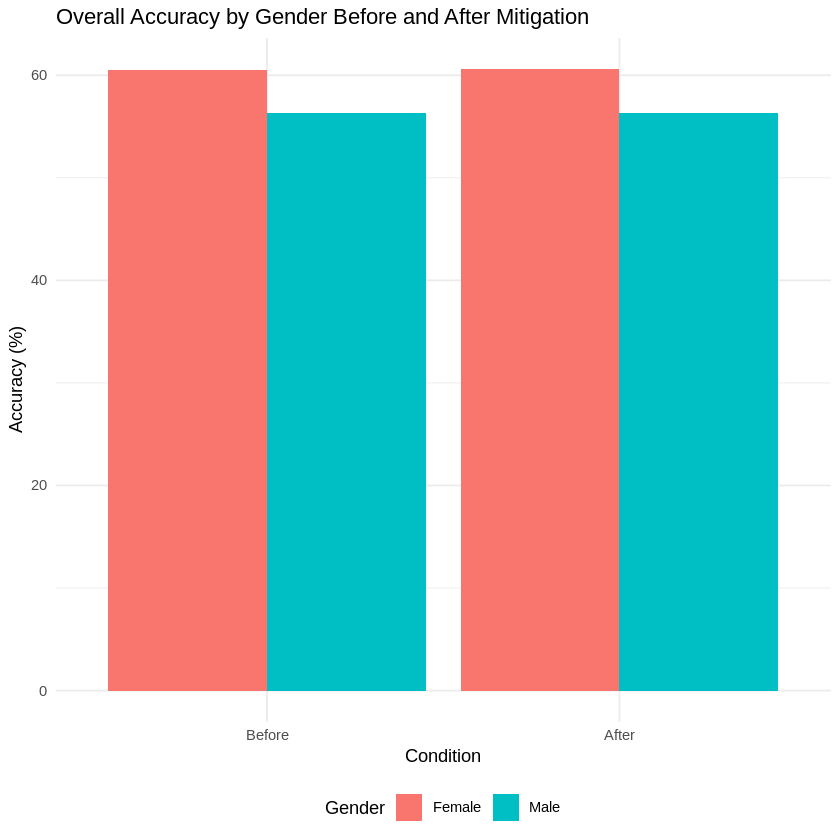

In [133]:
accuracy_comparison <- model_data %>%
  group_by(gender) %>%
  summarise(
    Accuracy_Before = mean(Prediction_Correct_Before) * 100,
    Accuracy_After = mean(Prediction_Correct_After) * 100
  )

print(accuracy_comparison)

# Prepare data for plotting
accuracy_gender_long <- accuracy_comparison %>%
  pivot_longer(
    cols = c("Accuracy_Before", "Accuracy_After"),
    names_to = "Condition",
    values_to = "Accuracy"
  ) %>%
  mutate(
    # Convert Condition to a factor and specify the desired order and labels
    Condition = factor(Condition, levels = c("Accuracy_Before", "Accuracy_After"), labels = c("Before", "After")),
    # Ensure gender is a factor with desired order
    gender = factor(gender, levels = c("Female", "Male"))
  )

# Plot the accuracy by condition before and after mitigation
ggplot(accuracy_gender_long, aes(x = Condition, y = Accuracy, fill = gender)) +
  geom_bar(stat = 'identity', position = 'dodge') +
  labs(
    title = 'Overall Accuracy by Gender Before and After Mitigation',
    x = 'Condition',
    y = 'Accuracy (%)',
    fill = 'Gender'
  ) +
  theme_minimal() +
  theme(
    legend.position = "bottom"
  )

Compare by Overall accuracy

  Accuracy_Before Accuracy_After
1        58.28008       58.35311


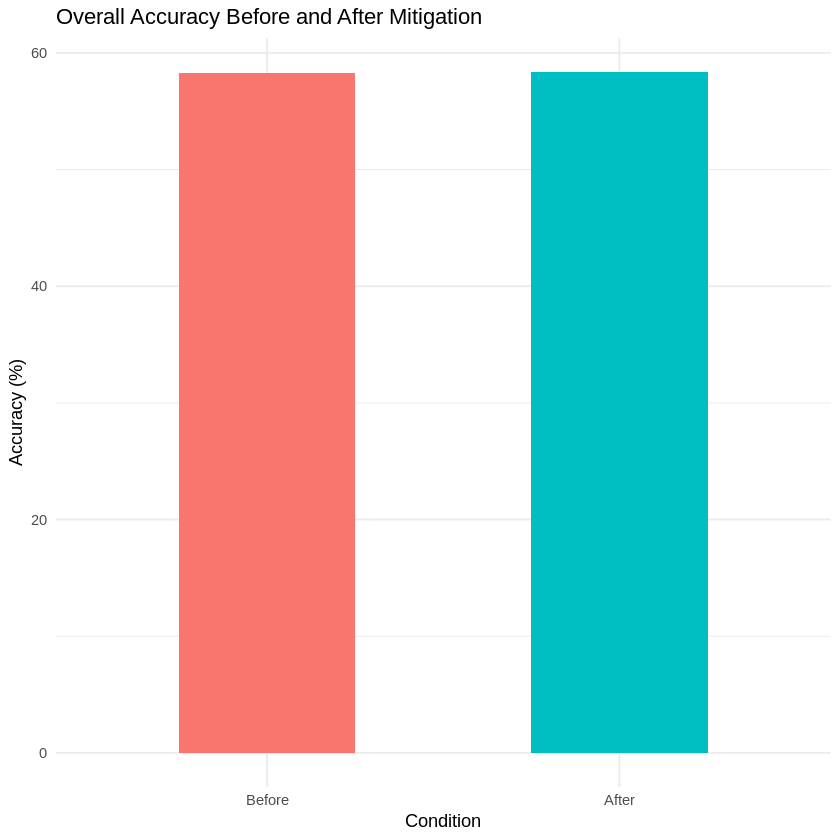

In [134]:
overall_accuracy <- model_data %>%
  summarise(
    Accuracy_Before = mean(Prediction_Correct_Before) * 100,
    Accuracy_After = mean(Prediction_Correct_After) * 100
  )

print(overall_accuracy)

# Prepare data for plotting
overall_accuracy_long <- overall_accuracy %>%
  pivot_longer(
    cols = c("Accuracy_Before", "Accuracy_After"),
    names_to = "Condition",
    values_to = "Accuracy"
  ) %>%
  mutate(
    # Simplify the Condition labels
    Condition = factor(Condition, levels = c("Accuracy_Before", "Accuracy_After"), labels = c("Before", "After"))
  )

# Plot the overall accuracy before and after mitigation
ggplot(overall_accuracy_long, aes(x = Condition, y = Accuracy, fill = Condition)) +
  geom_bar(stat = 'identity', width = 0.5) +
  labs(
    title = 'Overall Accuracy Before and After Mitigation',
    x = 'Condition',
    y = 'Accuracy (%)',
    fill = 'Condition'
  ) +
  theme_minimal() +
  theme(
    legend.position = "none"
  )